In [88]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from collections import Counter

## Load Data

In [10]:
dom1 = []
dom2 = []
test_set = []
with open('../data/domain1_train.json', 'r') as file:
    for line in file:
        dom1.append(json.loads(line))
        
with open('../data/domain2_train.json', 'r') as file:
    for line in file:
        dom2.append(json.loads(line))
        
sam = pd.read_csv("../data/sample.csv")

with open('../data/test_set.json', 'r') as file:
    for line in file:
        test_set.append(json.loads(line))
        
dom1 = pd.DataFrame.from_dict(dom1)
dom2 = pd.DataFrame.from_dict(dom2)
dom2 = dom2[dom2['text'].apply(len) > 0]
dom = pd.concat([dom1,dom2])

## EDA

In [130]:
def word_freq(domain, name, dom_name):
    counter = Counter()
    for text in domain['text']:
        counter = dict(Counter(text) + Counter(counter))
    
    token_id = list(counter.keys())
    token_count = list(counter.values())

    print("The mean count of word frequency is: ", np.mean(token_count))
    print("The max count of word frequency is: ", max(token_count))
    print("The min count of word frequency is: ", min(token_count))

    plt.figure(figsize=(8,4))
    plt.bar(token_id, token_count)
    plt.xlabel("Frequency")
    plt.xlim([0, 200])
    plt.title("Word Freqency in "+ str(name) +" Domain " + str(dom_name))
    plt.show()

In [131]:
# split human and machine texts

dom1_grouped = dom1.groupby('label')
dom2_grouped = dom2.groupby('label')

dom1_ai = dom1_grouped.get_group(0)  
dom1_man = dom1_grouped.get_group(1)  
dom2_ai = dom2_grouped.get_group(0)  
dom2_man = dom2_grouped.get_group(1) 

The mean count of word frequency is:  113.07946725860155
The max count of word frequency is:  45769
The min count of word frequency is:  1


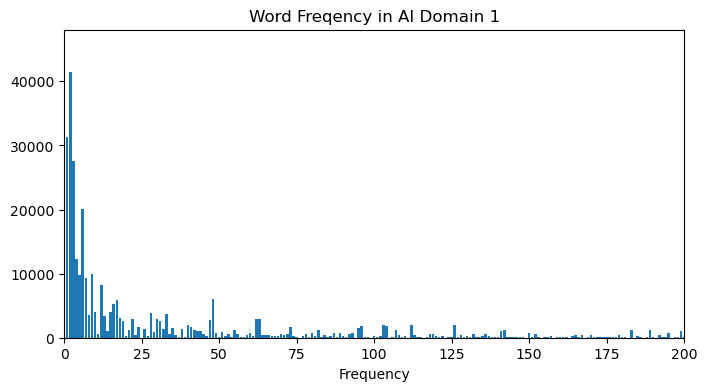

In [132]:
word_freq(dom1_ai, 'AI', "1")

The mean count of word frequency is:  55.002274607113314
The max count of word frequency is:  44068
The min count of word frequency is:  1


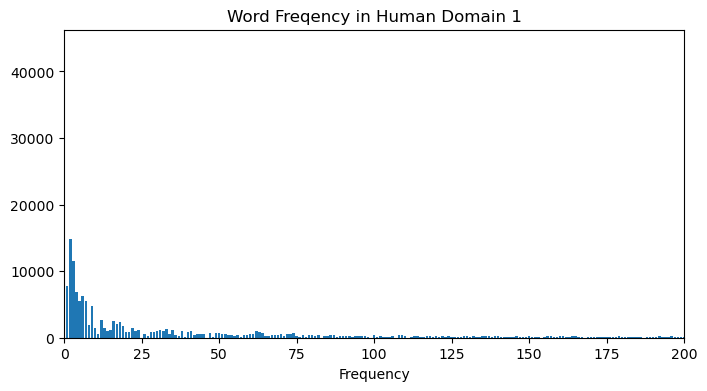

In [111]:
word_freq(dom1_man, 'Human', "1")

The mean count of word frequency is:  377.156054174247
The max count of word frequency is:  146042
The min count of word frequency is:  1


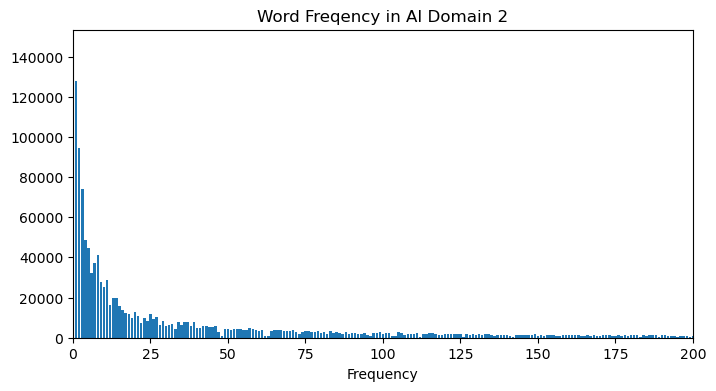

In [112]:
word_freq(dom2_ai, "AI", "2")

The mean count of word frequency is:  94.92816442816442
The max count of word frequency is:  50768
The min count of word frequency is:  1


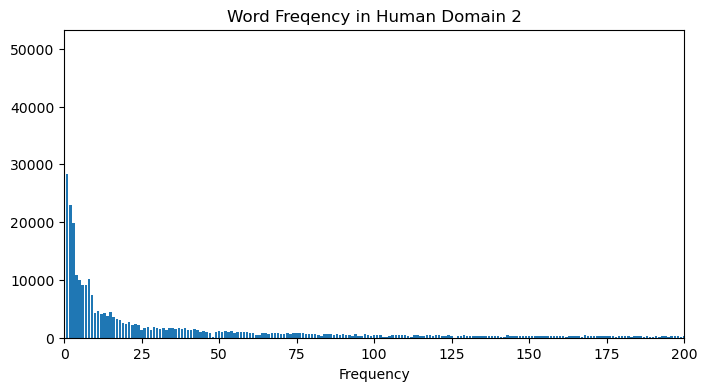

In [113]:
word_freq(dom2_man, "Human", "2")

In [114]:
print("Average length of instances in each domain: \n")

print("domain 1 AI")
print(dom1_ai['text'].str.len().mean())
print("domain 1 human")
print(dom1_man['text'].str.len().mean())
print("domain 2 AI")
print(dom2_ai['text'].str.len().mean())
print("domain 2 human")
print(dom2_man['text'].str.len().mean())

Average length of instances in each domain: 

domain 1 AI
52.249435897435895
domain 1 human
27.281128205128205
domain 2 AI
146.33654901960784
domain 2 human
217.06700791065612


#### Original Label Distribution

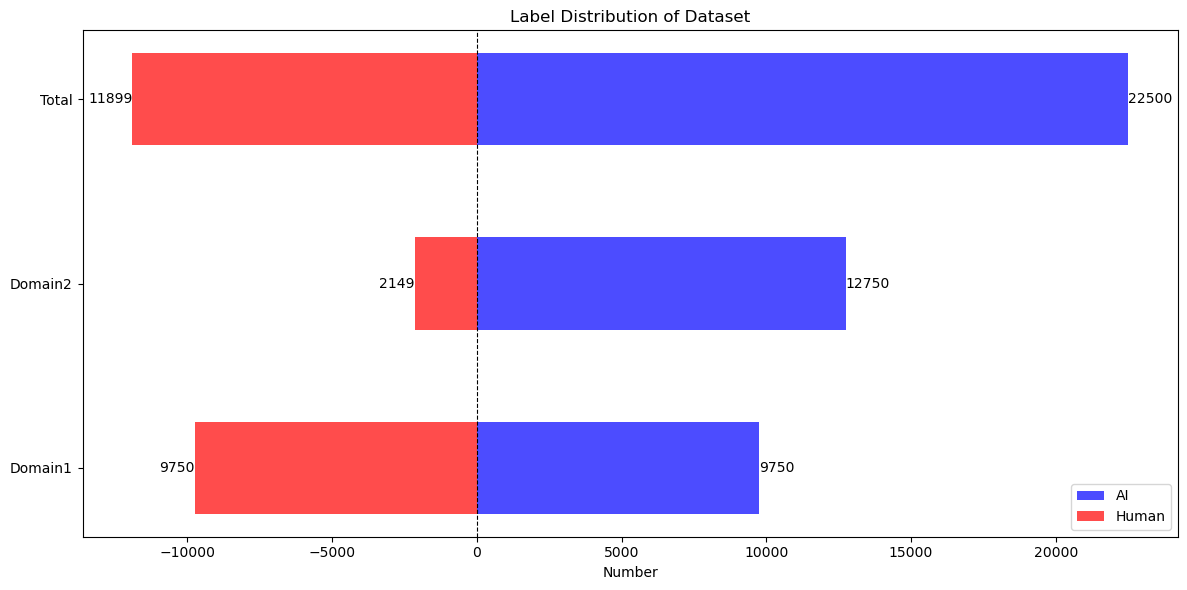

In [125]:
# data
categories = ['Domain1', 'Domain2', 'Total']
values_AI = [dom1['label'].value_counts()[0], 
             dom2['label'].value_counts()[0],
             dom['label'].value_counts()[0]] 
values_Human = [-dom1['label'].value_counts()[1], 
                -dom2['label'].value_counts()[1],
                -dom['label'].value_counts()[1]]

# Create x-axis positions
x = np.arange(len(categories))
plt.figure(figsize=(12, 6)) 

# Plot bars
bars_AI = plt.barh(x, values_AI, color='b', label='AI', alpha=0.7, height=0.5)
bars_Human = plt.barh(x, values_Human, color='r', label='Human', alpha=0.7, height=0.5)

# Add a vertical line at the center (baseline)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Add values to the bars
for bar_AI, bar_Human, value_AI, value_Human in zip(bars_AI, bars_Human, values_AI, values_Human):
    plt.text(bar_AI.get_width(), bar_AI.get_y() + bar_AI.get_height() / 2, str(value_AI), ha='left', va='center')
    plt.text(bar_Human.get_width(), bar_Human.get_y() + bar_Human.get_height() / 2, str(-value_Human), ha='right', va='center')

plt.yticks(x, categories)
plt.xlabel('Number')
plt.title('Label Distribution of Dataset')
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('label.png', dpi=300, bbox_inches='tight')
plt.show()


## Resample 

In [116]:
# human as model 8, dom1 AI as model 7
dom1['model'] = np.where(dom1['label'] == 1, 8, 7)
dom2["model"] = dom2["model"].replace(np.nan, 8)

dom2_0 = dom2.loc[dom2['label']==0]
dom2_1 = dom2.loc[dom2['label']==1]

length_dom2_1 = len(dom2_1)
mol_num = len(dom2['model'].value_counts())
least_mol_num = length_dom2_1/(mol_num-1)
sam_dom2_0 = dom2_0.groupby('model').apply(lambda x: x.sample(n=int(least_mol_num)))
sam_dom2_0.reset_index(drop=True, inplace=True)
dom2_even = result = pd.concat([dom2_1, sam_dom2_0])

df = pd.concat([dom1, dom2_even])
df = df.sample(frac=1).reset_index(drop=True)

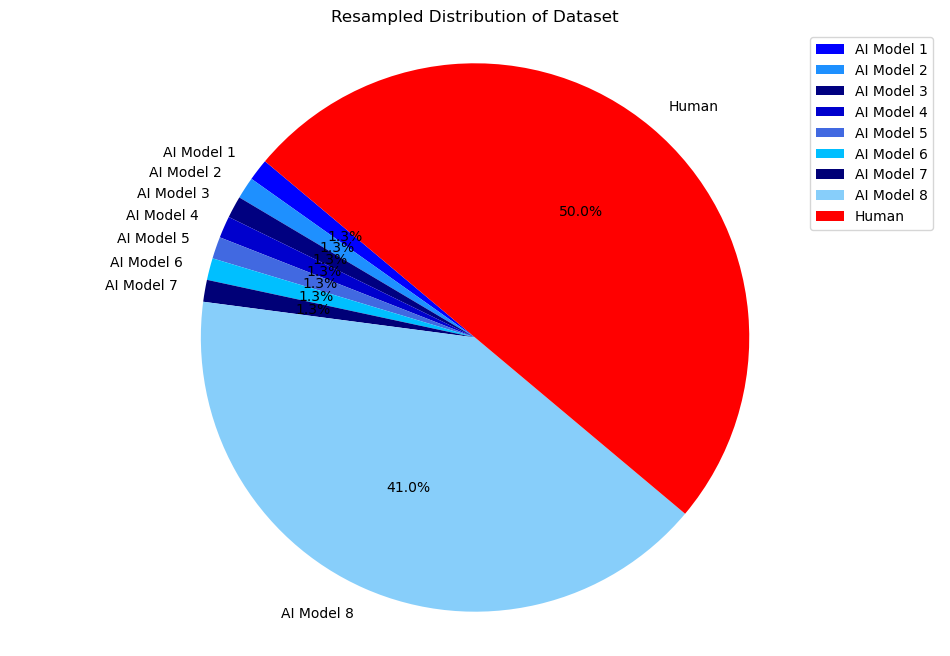

In [117]:
model8_num = df['model'].value_counts()[8]
model7_num = df['model'].value_counts()[7]
modelrest_num = df['model'].value_counts()[0]

labels = ['AI Model 1', 'AI Model 2', 'AI Model 3', 'AI Model 4', 'AI Model 5', 'AI Model 6', 
          'AI Model 7','AI Model 8', 'Human']
sizes = [modelrest_num, modelrest_num, modelrest_num, modelrest_num, modelrest_num, 
         modelrest_num, modelrest_num, model7_num, model8_num]   # Sample sizes for each category
colors = ['#0000FF', '#1E90FF', '#000080', '#0000CD', '#4169E1', '#00BFFF', '#000077', '#87CEFA', 'red']

plt.figure(figsize=(12, 8)) 
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.title('Resampled Distribution of Dataset')

plt.axis('equal') 
plt.legend()
plt.savefig('Resample.png', dpi=300, bbox_inches='tight')
plt.show()